# Multiobjective optimization using differential evolution

In the introduction, three multiobjective optimization problems were described and the Pareto fronts of the problems were found by sampling the space with a large number of points and using a non-dominated sorting algorithm that finds a set of non-dominated solutions within the sampled points. In the case of troublesome Pareto fronts, this approach can be computationally expensive as a large number of sampling points may be required to accurately find the Pareto front. In this section, the non-dominated sorting differential evolution (NSDE) algorithm is introduced and used to solve the same three optimization problems. This algorithm uses the non-dominated sorting method and applies it to each population of the differential evolution algorithm. That along with other heuristics such as crowding functions can ensure that the algorithm finds the Pareto frontier of a problem more efficiently than just using the non-dominated sorting algorithm.

The block of code below imports the required packages for this section

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoode.algorithms import NSDE
from pymoode.survival import RankAndCrowding
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.termination.default import DefaultMultiObjectiveTermination

## Branin-Currin optimization problem

The Branin-Currin optimization problem was described in the previous section. The block of code below defines the two objective functions of the problem.

In [28]:
# Defining the objective functions
def branin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = 15*x[:,0] - 5
    x2 = 15*x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (1/51.95)*((x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 - 44.81)

    if dim == 1:
        y = y.reshape(-1)

    return y

def currin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    factor = 1 - np.exp(-1/(2*x2))
    num = 2300*x1**3 + 1900*x1**2 + 2092*x1 + 60
    den = 100*x1**3 + 500*x1**2 + 4*x1 + 20
    y = factor*num/den
    
    if dim == 1:
        y = y.reshape(-1)

    return y

The blocks of code below defines the `problem` class for the optimization problem. The optimization problem is solved using the `NSDE` algorithm that is given in `pymoo`. 

In [29]:
# Defining the problem class for pymoo - we are evaluating two objective functions in this case
class BraninCurrin(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([1e-6, 1e-6]), xu=np.array([1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack((branin(x), currin(x)))

In [30]:
termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-4,
    ftol=1e-4,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = BraninCurrin()
algorithm = NSDE(pop_size=100, CR=0.9, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
res_nsde = minimize(problem, algorithm, verbose=False)

To visualize the convergence of the algorithm, the set of non-dominated points found at each generation of NSDE are plotted at specific iterations of the algorithm. The plots show that the set of non-dominated points converges to the Pareto front of the problem as the iterations progress.

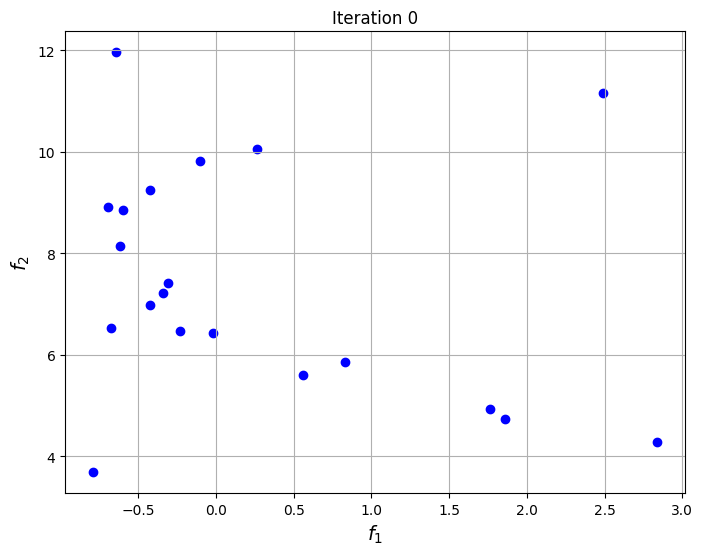

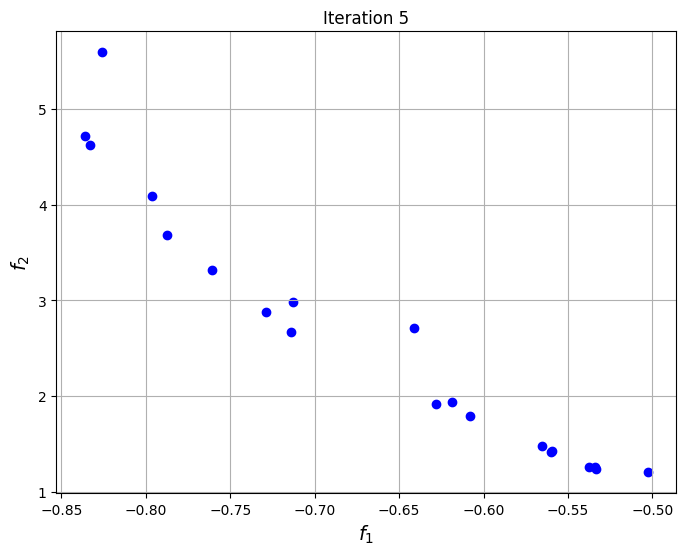

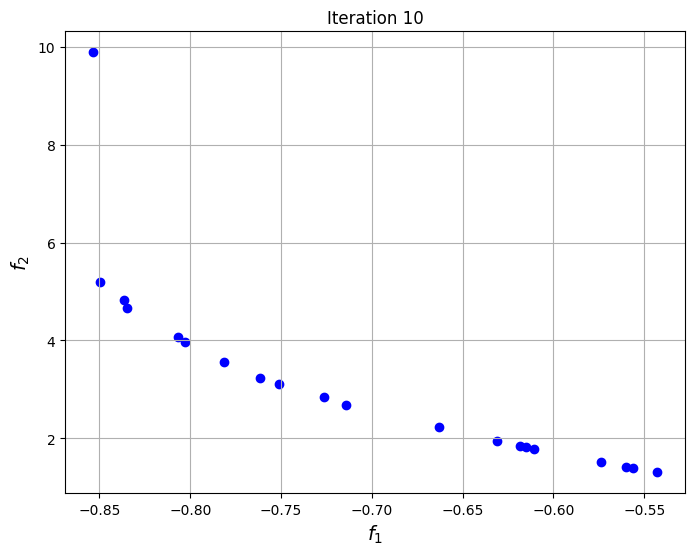

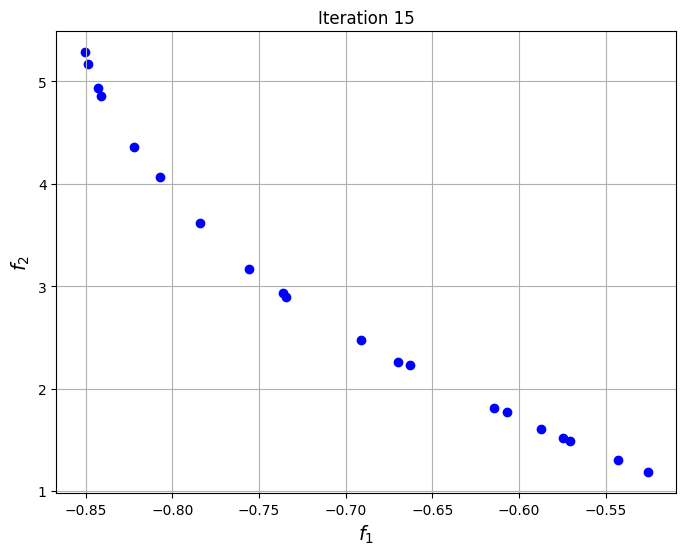

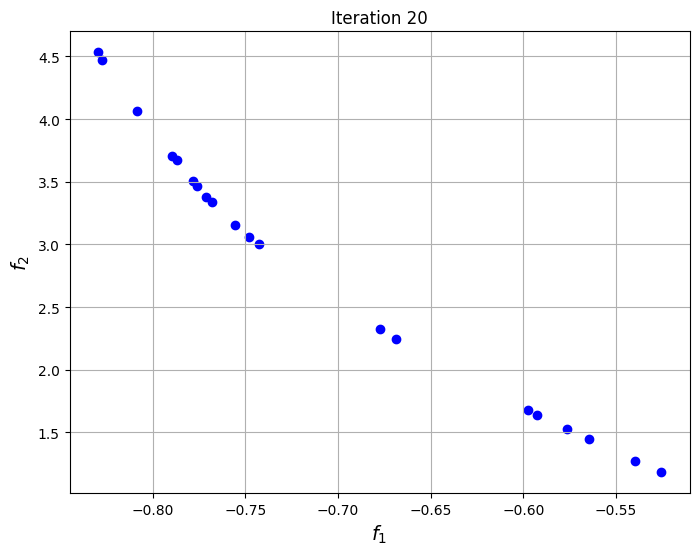

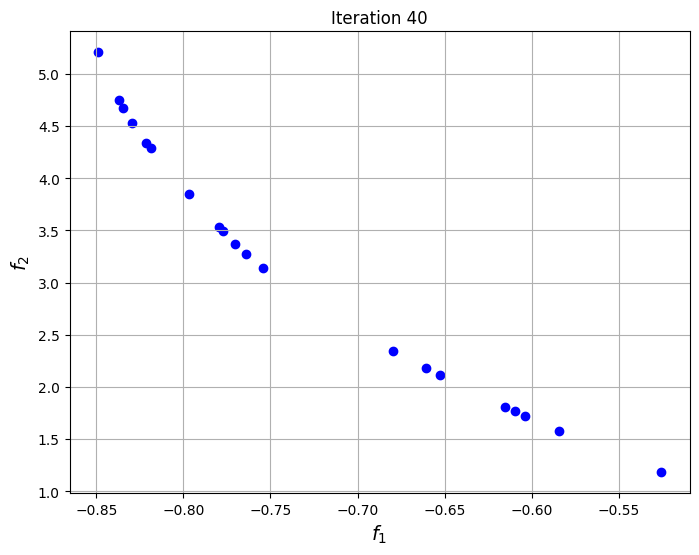

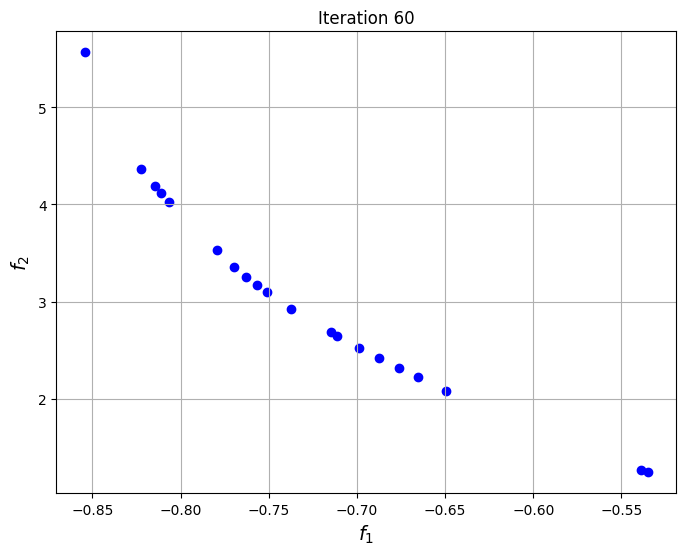

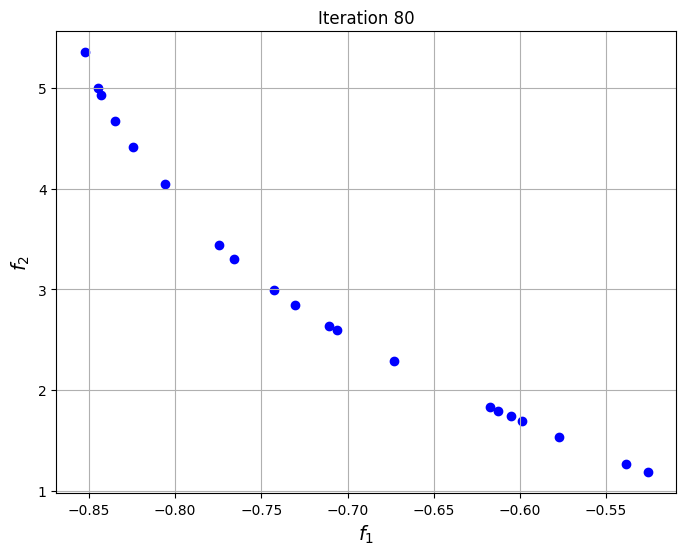

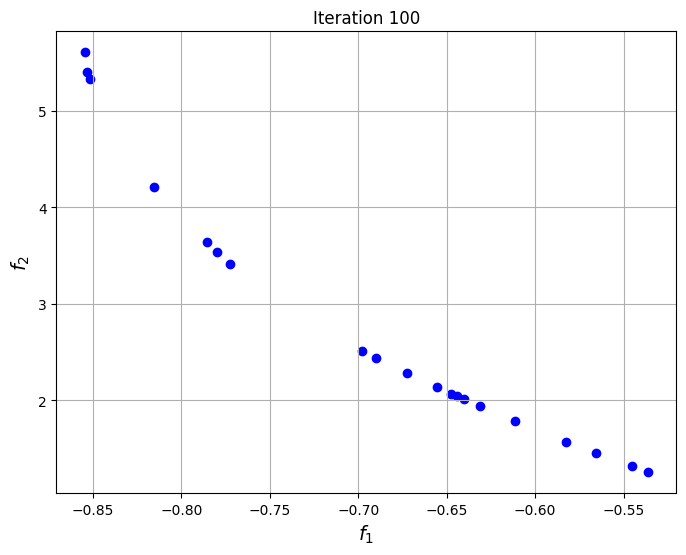

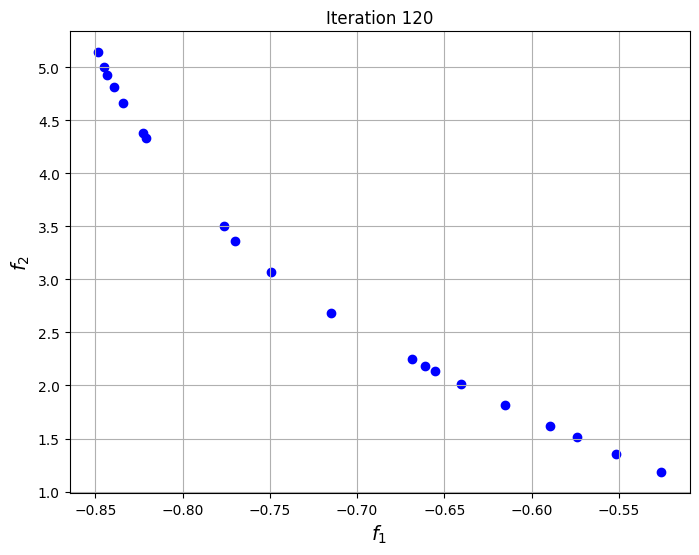

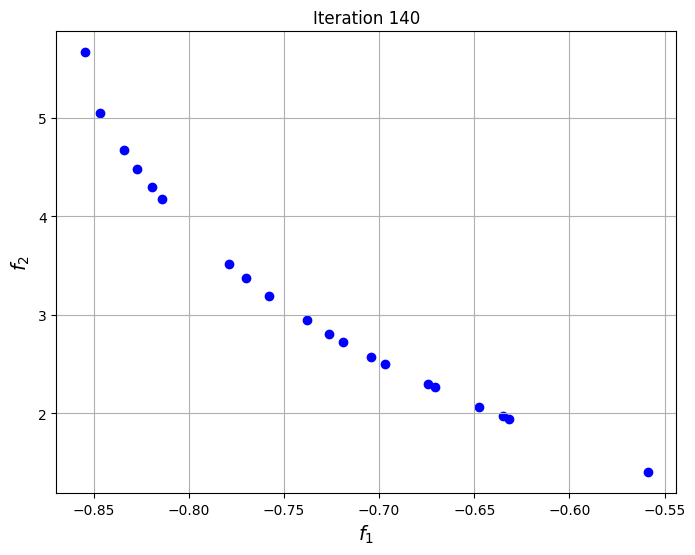

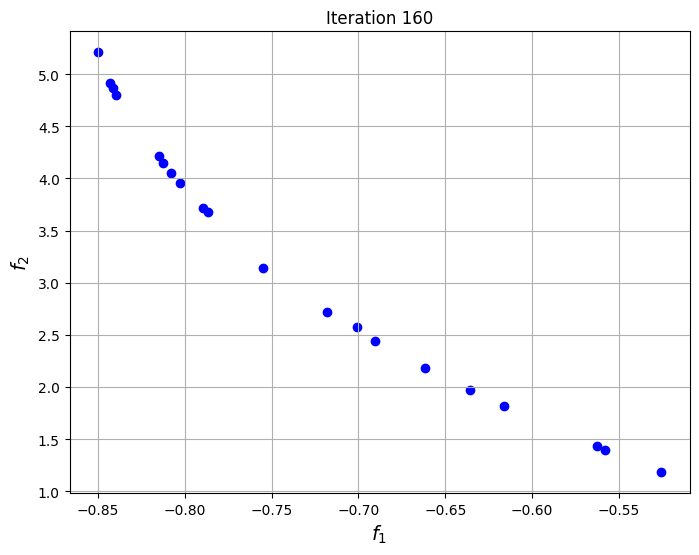

In [31]:
niter = len(res_nsde.history) # Number of iterations
iterations = np.arange(0,20,5)
iterations = np.concatenate((iterations, np.arange(20,niter,20)))

# Plotting the particle evolution
for itr in iterations:
    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.scatter(res_nsde.history[itr].pop.get("F")[::5, 0], res_nsde.history[itr].pop.get("F")[::5, 1], color = "blue")
    ax.set_title("Iteration %s" % itr)
    ax.grid()
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.set_ylabel("$f_2$", fontsize = 14)

The block of code below plots the final Pareto front obtained for the problem and comapares it to the one found using non-dominated sorting alone. The Pareto front obtained using differential evolution is identical to the one obtained using non-dominated sorting indicating that the NSDE algorithm works well for the problem. 

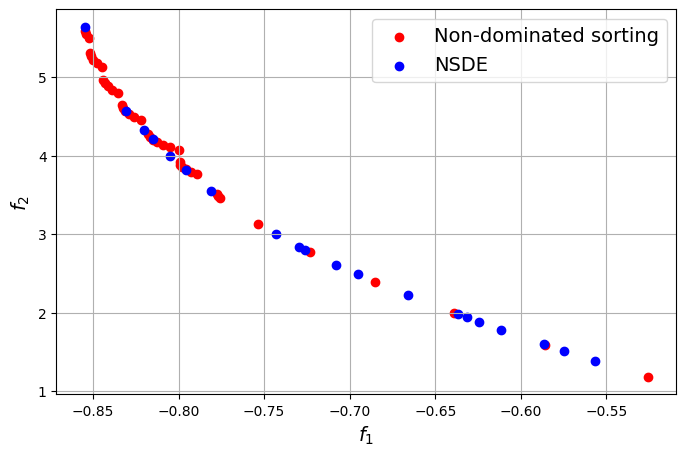

In [32]:
# Generating a grid of points
num_points = 100

# Defining x and y values
x = np.linspace(1e-6,1,num_points)
y = np.linspace(1e-6,1,num_points)

# Creating a mesh
X, Y = np.meshgrid(x, y)

# Finding the front through non-dominated sorting
z1 = branin(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
z2 =  currin(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
nds = NonDominatedSorting()
F = np.column_stack((z1,z2))
pareto = nds.do(F, n_stop_if_ranked=50)
Z_pareto = F[pareto[0]]

# Plotting final Pareto frontier obtained
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(Z_pareto[1:,0], Z_pareto[1:,1], color="red", label="Non-dominated sorting")
ax.scatter(res_nsde.F[::5, 0], res_nsde.F[::5, 1], color="blue", label="NSDE")
ax.set_ylabel("$f_2$", fontsize = 14)
ax.set_xlabel("$f_1$", fontsize = 14)
ax.legend(fontsize = 14)
ax.grid()

## Constrained optimization problem

In [40]:
# Defining the objective functions
def f1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = 4*x[:,0]**2 + 4*x[:,1]**2
    
    return y
    
def f2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = (x[:,0]-5)**2 + (x[:,1]-5)**2

    return y

def g1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = (x[:,0]-5)**2 + x[:,1]**2 - 25

    return g

def g2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = 7.7 - ((x[:,0]-8)**2 + (x[:,1]+3)**2)

    return g

# Defining the problem class for pymoo - we are evaluating two objective and two constraint functions in this case
class ConstrainedProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, vtype=float)

        self.xl = np.array([-20.0, -20.0])
        self.xu = np.array([20.0, 20.0])

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack([f1(x), f2(x)])
        out["G"] = np.column_stack([g1(x), g2(x)])

In [41]:
termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-4,
    ftol=1e-4,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = ConstrainedProblem()
nsde = NSDE(pop_size=200, CR=0.8, termination = termination, survival=RankAndCrowding(crowding_func="pcd"), save_history = True)
res_nsde = minimize(problem, nsde, verbose=False)

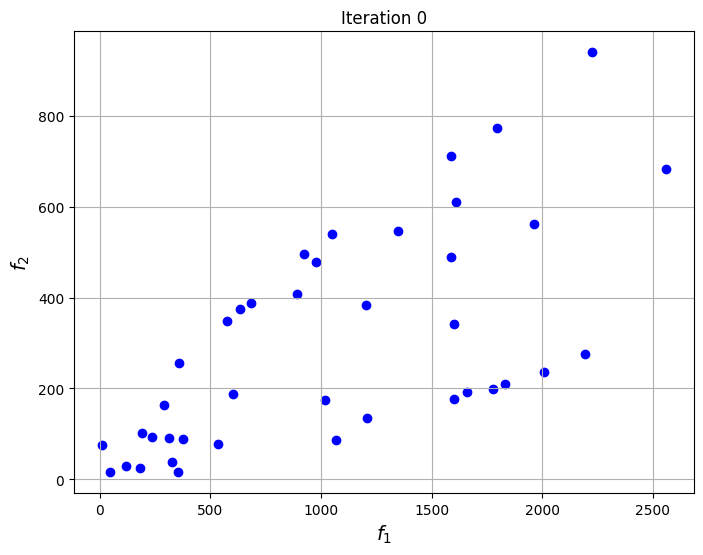

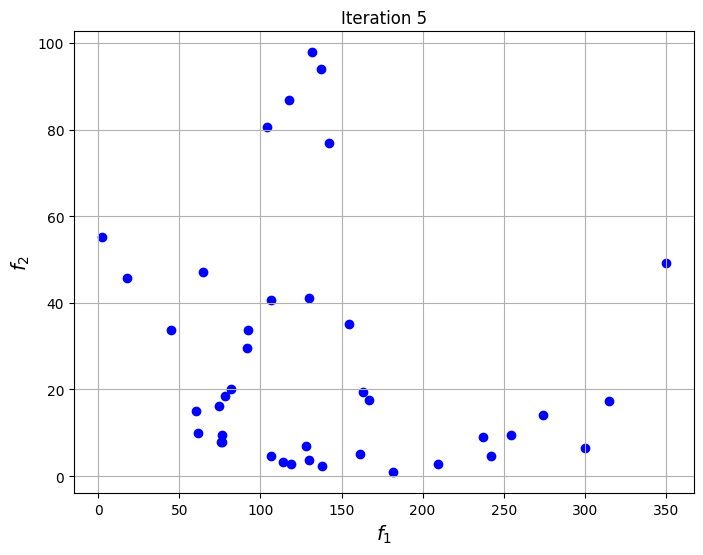

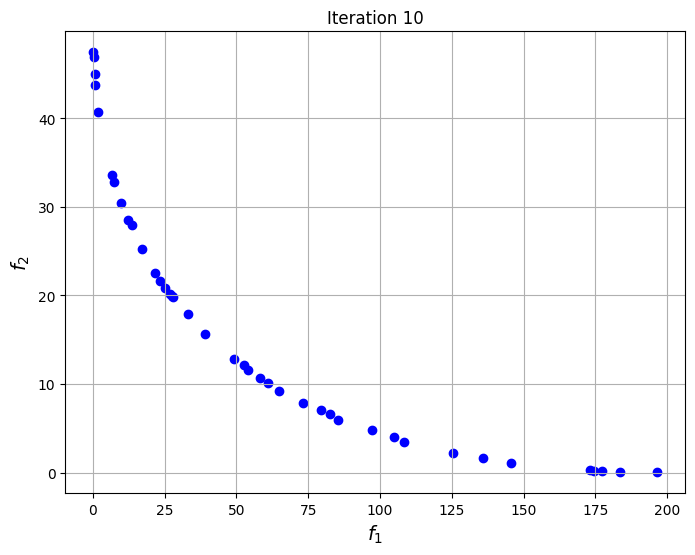

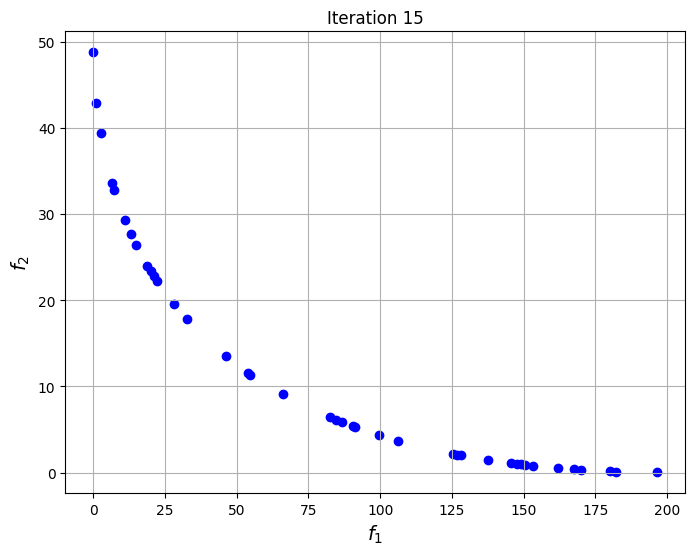

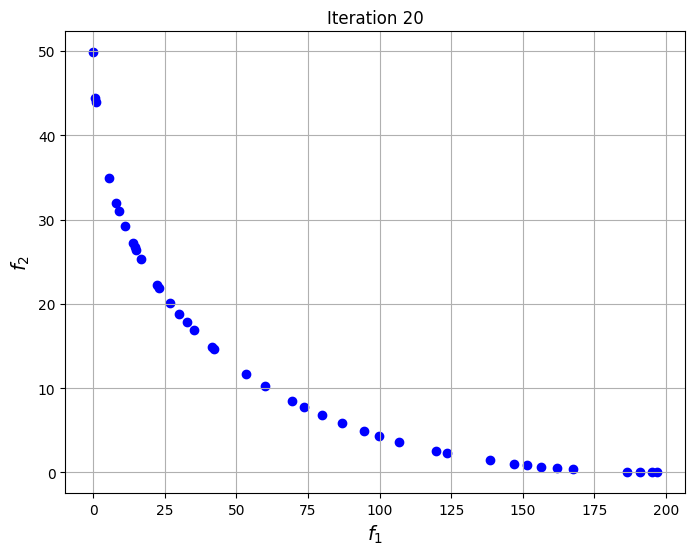

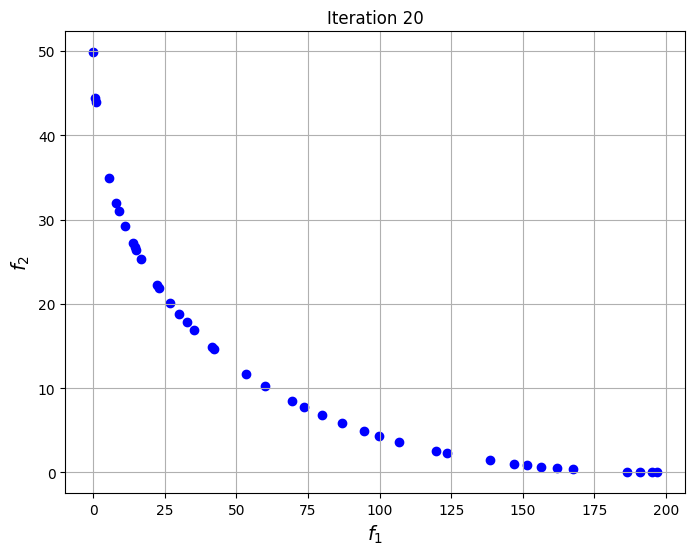

In [42]:
niter = len(res_nsde.history) # Number of iterations
iterations = np.arange(0,25,5)
iterations = np.concatenate((iterations, np.arange(20,niter,50)))

# Plotting the particle evolution
for itr in iterations:
    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.scatter(res_nsde.history[itr].pop.get("F")[::5, 0], res_nsde.history[itr].pop.get("F")[::5, 1], color = "blue")
    ax.set_title("Iteration %s" % itr)
    ax.grid()
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.set_ylabel("$f_2$", fontsize = 14)

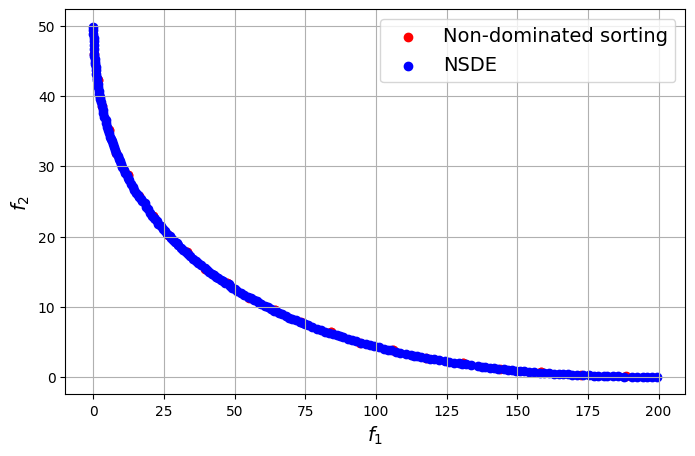

In [43]:
# Generating a grid of points
num_points = 100

# Defining x and y values
x = np.linspace(-20,20,num_points)
y = np.linspace(-20,20,num_points)

# Creating a mesh
X, Y = np.meshgrid(x, y)

# Finding the front through non-dominated sorting
z1 = f1(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
z2 = f2(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
const1 = g1(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
const2 = g2(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))))
z1 = z1[(const1<0) & (const2<0)]
z2 = z2[(const1<0) & (const2<0)]
nds = NonDominatedSorting()
F = np.column_stack((z1,z2))
pareto = nds.do(F, n_stop_if_ranked=50)
Z_pareto = F[pareto[0]]

# Plotting final Pareto frontier obtained
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(Z_pareto[:,0], Z_pareto[:,1], color="red", label="Non-dominated sorting")
ax.scatter(res_nsde.F[:, 0], res_nsde.F[:, 1], color="blue", label="NSDE")
ax.set_ylabel("$f_2$", fontsize = 14)
ax.set_xlabel("$f_1$", fontsize = 14)
ax.legend(fontsize = 14)
ax.grid()